In [1]:
import numpy as np
import xarray as xr
from oceanmodes import instability_analysis_from_N2_profile as insta
from oceanmodes import neutral_modes_from_N2_profile as neu
from scipy.interpolate import PchipInterpolator as pchip
import gsw
import os.path as op
from dask.diagnostics import ProgressBar
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ddir = '/swot/SUM05/takaya/MITgcm/channel/runs/'

In [3]:
ys, dy = (35,23)
dt = 3e2
df = 288
ts = int((ys*360*86400)/dt)
te = int(ts + dy*360*86400/dt)
print(ts,te)

3628800 6013440


In [4]:
ds1 = open_mdsdataset(op.join(ddir,'MOM-KPP_05km'), grid_dir=op.join(ddir,'5km_grid'),
                     iters=range(ts,te,df), prefix=['MOMtave'], delta_t=dt
                     )
ds1

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (XC: 200, XG: 200, YC: 400, YG: 400, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 8280)
Coordinates:
  * XC       (XC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * YC       (YC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * XG       (XG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 30000.0 ...
  * YG       (YG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 30000.0 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * Zp1      (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zu       (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 -16.1 ...
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
    rA       (YC, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    dxG      (YG, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    dyG      (YC, XG) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    Depth    (YC

In [5]:
grid = Grid(ds1, periodic=['X'])
grid

<xgcm.Grid>
T Axis (not periodic):
  * center   time (8280)
Z Axis (not periodic):
  * center   Z (76) --> left
  * left     Zl (76) --> center
  * outer    Zp1 (77) --> center
  * right    Zu (76) --> center
X Axis (periodic):
  * center   XC (200) --> left
  * left     XG (200) --> center
Y Axis (not periodic):
  * center   YC (400) --> left
  * left     YG (400) --> center

## $$N^2 = -\frac{g}{\rho_0}\frac{\partial\rho}{\partial z} = \alpha g\frac{\partial\theta}{\partial z}$$

In [6]:
seas = np.tile(np.repeat(range(4),90),dy)
temp = ds1.THETA
temp.coords['seas'] = ('time',seas)
temp_seas = temp.groupby('seas').mean(['time','XC'])
alpha = 2e-4
g = 9.81
f0 = -1.1e-4
beta = 1.4e-11
with ProgressBar():
    N2_seas = alpha*g * (grid.diff(temp_seas,'Z',boundary='fill')
                        / grid.diff(temp_seas.Z,'Z',boundary='fill')
                        ).compute()
N2_seas

[########################################] | 100% Completed | 20min 19.1s


<xarray.DataArray (seas: 4, Zl: 76, YC: 400)>
array([[[-0.000000e+00, -2.944260e-03, ..., -3.113911e-02, -3.121319e-02],
        [-0.000000e+00, -2.177350e-06, ...,  3.731507e-04,  3.639709e-04],
        ...,
        [-0.000000e+00,  1.007608e-08, ...,  5.018076e-06,  5.028059e-06],
        [-0.000000e+00,  3.679822e-09, ...,  1.015483e-06,  9.700071e-07]],

       [[-0.000000e+00, -2.934080e-03, ..., -3.098386e-02, -3.113265e-02],
        [-0.000000e+00, -2.219319e-06, ...,  3.703974e-04,  3.670871e-04],
        ...,
        [-0.000000e+00,  1.002800e-08, ...,  5.016810e-06,  5.026221e-06],
        [-0.000000e+00,  3.643686e-09, ...,  1.011224e-06,  9.658858e-07]],

       [[-0.000000e+00, -2.911963e-03, ..., -3.090395e-02, -3.107493e-02],
        [-0.000000e+00, -2.236915e-06, ...,  4.350451e-04,  4.385329e-04],
        ...,
        [-0.000000e+00,  9.951448e-09, ...,  5.024214e-06,  5.032146e-06],
        [-0.000000e+00,  3.579695e-09, ...,  1.015596e-06,  9.702865e-07]],

       [[

In [35]:
# dsave = temp.to_dataset(name='Ttave')
# dsave.to_netcdf(op.join(ddir,'Ttave_5km_20-29yr.nc'))
Tclim = xr.open_dataset(op.join(ddir,'Climatological-theta_05km.nc')).THETA_clim

<a list of 6 text.Text objects>

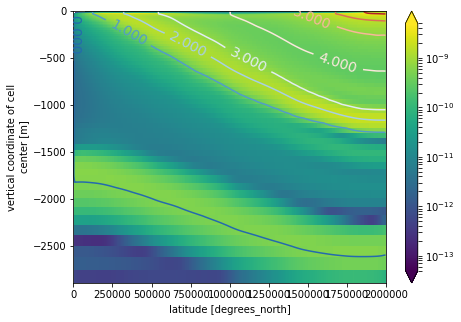

In [12]:
fig, ax = plt.subplots(figsize=(7,5))
(N2_seas.mean('seas')*np.abs(f0 + beta*ds1.YC)**-1).plot(ax=ax, vmin=5e-4,vmax=5e1,norm=clr.LogNorm())
im = Tclim.plot.contour(ax=ax, levels=np.linspace(0,8,11), cmap='RdBu_r')
plt.clabel(im, fontsize=14)

In [7]:
# ds2 = open_mdsdataset(op.join(ddir,'deepML-2mon_5kmMOM'), grid_dir=op.join(ddir,'5km_grid'), 
#                      iters=range(ts-dF+8640,te,8640), prefix=['MOMtave'], delta_t=dt
#                      )
# ds2

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = X
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (XC: 200, XG: 200, YC: 400, YG: 400, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 120)
Coordinates:
  * XC       (XC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * YC       (YC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * XG       (XG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 30000.0 ...
  * YG       (YG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 30000.0 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * Zp1      (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zu       (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 -16.1 ...
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
    rA       (YC, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    dxG      (YG, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    dyG      (YC, XG) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    Depth    (YC,

In [7]:
phi = ds1.PHIHYD
phi.coords['seas'] = ('time',np.tile(np.repeat(range(4),90),dy))
with ProgressBar():
    phi_seas = phi.groupby('seas').mean(['time','XC']).compute()
phi_seas

[################################        ] | 80% Completed | 33min 53.1s


KeyboardInterrupt: 

In [ ]:
f = f0 + beta*(ds1.YC-ds1.YC.mean())
ug = -grid.diff(phi_seas,'Y',boundary='fill')/grid.diff(phi_seas.YC,'Y',boundary='fill')
# vg = grid.diff(phi_seas,'X')/grid.diff(phi_seas.XC,'X')
ug = grid.interp(ug,'Y',boundary='fill') * f**-1
# vg = grid.interp(vg,'X') * f**-1

In [ ]:
MLD = xr.open_dataset(op.join(ddir,'KPPMLD_05km.nc')).mld
with ProgressBar():
    MLD_seas = MLD.groupby('seas').mean(['time','XC']).compute()
MLD_seas

In [ ]:
colors = ['red','brown','blue','green']
seasons = ['JFM','AMJ','JAS','OND']

fig, (ax1,ax2) = plt.subplots(figsize=(8,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
for i in range(len(N2_seas.seas)):
    ax1.plot(N2_seas[i,1:45].sel(YC=12.5e5,method='nearest'), ds1.Zl[1:45], color=colors[i], lw=2, label=seasons[i])
    ax1.plot(np.linspace(1e-8,3e-5,5), -np.ones(5)*MLD_seas.sel(YC=12.5e5,method='nearest').data[i], 
             color=colors[i], ls='--')
    ax2.plot(ug[i,:45].sel(YC=12.5e5,method='nearest'), ds1.Z[:45], color=colors[i], lw=2, label=seasons[i])
ax1.set_xlim([2e-8,2.4e-5])
ax1.set_xscale('log')
ax1.set_xlabel(r'$N^2$ [s$^{-2}$]',fontsize=14)
ax1.set_ylabel(r'Depth [m]',fontsize=14)
ax1.legend(loc='lower left', fontsize=12)
plt.savefig(op.join(ddir,'Figures/Background_Ug-N2.pdf'))

In [19]:
# kx = np.fft.fftshift(np.fft.fftfreq(len(ds1.XC),np.diff(ds1.XC)[0]))
# ky = np.fft.fftshift(np.fft.fftfreq(len(ds1.YC),np.diff(ds1.YC)[0]))
kx = np.arange(1e-6,5e-4,5e-7)
kx

array([1.000e-06, 1.500e-06, 2.000e-06, 2.500e-06, 3.000e-06, 3.500e-06,
       4.000e-06, 4.500e-06, 5.000e-06, 5.500e-06, 6.000e-06, 6.500e-06,
       7.000e-06, 7.500e-06, 8.000e-06, 8.500e-06, 9.000e-06, 9.500e-06,
       1.000e-05, 1.050e-05, 1.100e-05, 1.150e-05, 1.200e-05, 1.250e-05,
       1.300e-05, 1.350e-05, 1.400e-05, 1.450e-05, 1.500e-05, 1.550e-05,
       1.600e-05, 1.650e-05, 1.700e-05, 1.750e-05, 1.800e-05, 1.850e-05,
       1.900e-05, 1.950e-05, 2.000e-05, 2.050e-05, 2.100e-05, 2.150e-05,
       2.200e-05, 2.250e-05, 2.300e-05, 2.350e-05, 2.400e-05, 2.450e-05,
       2.500e-05, 2.550e-05, 2.600e-05, 2.650e-05, 2.700e-05, 2.750e-05,
       2.800e-05, 2.850e-05, 2.900e-05, 2.950e-05, 3.000e-05, 3.050e-05,
       3.100e-05, 3.150e-05, 3.200e-05, 3.250e-05, 3.300e-05, 3.350e-05,
       3.400e-05, 3.450e-05, 3.500e-05, 3.550e-05, 3.600e-05, 3.650e-05,
       3.700e-05, 3.750e-05, 3.800e-05, 3.850e-05, 3.900e-05, 3.950e-05,
       4.000e-05, 4.050e-05, 4.100e-05, 4.150e-05, 

In [380]:
print(N2.shape, ds1.Zl.shape, ug.shape, ds1.Z.shape)

(4, 40, 200) (40,) (4, 40, 200) (40,)


In [458]:
ug

<xarray.DataArray (seas: 4, Z: 76, YC: 400)>
dask.array<shape=(4, 76, 400), dtype=float32, chunksize=(1, 76, 1)>
Coordinates:
  * seas     (seas) int64 0 1 2 3
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * YC       (YC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...

In [20]:
nznew = 200
zNew = np.linspace(ds1.Zl[0], ds1.Zl[-1], nznew)
f = pchip(np.abs(ds1.Zl), N2_seas, axis=1)
N2intp = xr.DataArray(f(np.abs(zNew)), dims=['seas','znew','YC'],
                     coords={'seas':N2_seas.seas.data,'znew':zNew,'YC':N2_seas.YC}
                     )
zUew = np.linspace(ds1.Z[0], ds1.Z[-1], nznew)
f = pchip(np.abs(ds1.Z), ug, axis=1)
ugintp = xr.DataArray(f(np.abs(zUew)), dims=['seas','znew','YC'],
                     coords={'seas':range(4),'znew':zNew,'YC':ug.YC}
                     )

In [466]:
N2intp.sel(YC=slice(12e5,13.05e5)).shape,np.abs(ds1.Zp1.data[-1])

((4, 200, 21), 3000.0)

In [21]:
kd = np.zeros(4)
kwargs = {'num_eigen': 2, 'init_vector': None, 'num_Lanczos': nznew*10, 'iteration': nznew*100, 'tolerance': 0}
for i in range(len(N2_seas.seas)):
    zf, Rd, neuphi = neu(np.abs(zNew[1:]), N2intp.sel(YC=12.5e5,method='nearest')[i,1:], 
                        np.abs(f0), np.abs(ds1.Zp1.data[-1]),
                        **kwargs
                        )
    kd[i] = (2*np.pi*Rd[1])**-1
kd

/home/takaya/oceanmodes/oceanmodes/baroclinic.py:202: RuntimeWarning: invalid value encountered in power
  Rd = (-w)**-0.5 / np.absolute(f0)


array([1.01390163e-05, 1.01067369e-05, 1.01030062e-05, 1.01266121e-05])

In [ ]:
num = 2
omega = np.zeros((len(ug.seas),len(kx), 21), dtype=np.complex128)
# psi = np.zeros((len(ug.seas),len(kx), 11), dtype=np.complex128)
for i in range(len(ug.seas)):
    for j in range(21):
        zpsi, gr, psi = insta(np.abs(zNew[1:]), N2intp.sel(YC=slice(12e5,13.05e5))[i,1:,j], 
                             np.abs(f0), beta, 2*np.pi*kx, np.zeros(1),
                             np.abs(zUew), ugintp.sel(YC=slice(12e5,13.05e5))[i,:,j], np.zeros_like(zUew),
                             np.zeros(2), np.zeros(2), sort='LI', num=num
                             )
        omega[i,:,j] = gr[0,0]

In [210]:
omega.imag.std(axis=-1)*86400

array([[3.74574588e-15, 1.61673874e-15, 5.44774455e-16, 6.89885400e-16,
        9.90041720e-16, 1.37027582e-15, 5.30315088e-15, 8.01759290e-15,
        3.10506335e-15, 9.68249948e-15, 6.29023384e-15, 1.21234035e-14,
        1.67403333e-14, 1.69100335e-14, 2.35194869e-14, 7.01648121e-14,
        3.08147658e-14, 5.19075298e-14, 4.75434393e-14, 6.40687115e-14,
        1.46186176e-13, 5.18486133e-14, 5.14848376e-14, 6.81379892e-14,
        6.83223639e-14, 7.43040605e-14, 3.69143717e-14, 7.61638300e-14,
        2.60152949e-13, 2.29724811e-14, 2.17648959e-14, 2.25981767e-14,
        2.37744591e-14, 8.74259985e-15, 2.20011788e-14, 1.96245575e-14,
        1.82734309e-14, 1.33500741e-14, 1.81708346e-14, 2.13721785e-14,
        3.04874382e-14, 2.28473524e-14, 1.81076943e-14, 3.14529519e-14,
        3.06305598e-14, 1.43257674e-14, 3.02355039e-14, 3.55510721e-14,
        2.45392743e-14, 4.86502518e-14, 3.05754957e-14, 2.94290286e-14,
        4.23844499e-14, 2.23818751e-14, 2.30561342e-14, 4.512146

In [11]:
# ds3 = open_mdsdataset(op.join(ddir,'deepML-2mon_5kmKPP'), grid_dir=op.join(ddir,'5km_grid'),
#                      iters=range(ts,te,288),
#                      prefix=['KPPboundary'],
#                      delta_t=3e2
#                      )

# MLD = ds3.MXLDEPTH

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = X
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


In [12]:
# MLD.coords['seas'] = ('time',np.tile(np.repeat(range(4),90),10))
# MLD_seas = MLD.groupby('seas').mean(['time','XC'])
# MLD_seas

<xarray.DataArray 'MXLDEPTH' (seas: 4, YC: 400)>
dask.array<shape=(4, 400), dtype=float32, chunksize=(1, 400)>
Coordinates:
  * YC       (YC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * seas     (seas) int64 0 1 2 3

$$\sigma_{Eady} = \frac{U}{R_d} [...]^{1/2} = \frac{fU}{NH}[...]^{1/2} \sim f\sqrt{\frac{1}{H}\int\Big(\frac{(\partial u/\partial z)^2}{N^2}\Big) dz}\ [...]^{1/2}$$

Now, the $\mu$ inside the square brackets is defined as

$$\mu = \frac{NH}{f} \kappa_x = \pi R_d \cdot 2\pi k = \frac{\lambda_d}{2}\cdot 2\pi k = \pi \lambda_d k$$

In [473]:
N2_seas.sel(YC=12.5e5,method='nearest')

<xarray.DataArray (seas: 4, Zl: 76)>
dask.array<shape=(4, 76), dtype=float32, chunksize=(1, 1)>
Coordinates:
  * seas     (seas) int64 0 1 2 3
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
    YC       >f4 1252500.0

In [487]:
print(N2_seas.sel(YC=12.5e5,method='nearest')[0,:30].values)
print(N2_seas.sel(YC=12.5e5,method='nearest')[2,:30].values)

[-1.90683305e-02  8.41999054e-07  4.40937612e-07  3.10510217e-07
  2.49872215e-07  2.18038380e-07  2.01155544e-07  1.96267365e-07
  2.02528284e-07  2.23605298e-07  2.70544859e-07  3.85840622e-07
  8.92375226e-07  5.95333449e-06  1.16725214e-05  1.56545866e-05
  1.70903313e-05  1.65801448e-05  1.54829013e-05  1.40209195e-05
  1.25250608e-05  1.07729584e-05  9.00924806e-06  7.52322012e-06
  6.43078602e-06  5.62931427e-06  5.02521107e-06  4.57730812e-06
  4.24011478e-06  3.98785869e-06]
[-1.6449371e-02 -8.3412988e-07 -3.2054248e-07 -1.5290784e-07
 -6.8626868e-08 -2.0102828e-08  1.4044644e-08  3.7820282e-08
  5.8515955e-08  7.6700019e-08  9.6838100e-08  1.2369169e-07
  1.8625163e-07  4.4092408e-07  6.4371648e-07  9.1266151e-07
  1.1207493e-06  1.2355729e-06  1.2874033e-06  1.3587721e-06
  1.4831417e-06  1.5962507e-06  1.6887416e-06  1.7881279e-06
  1.8991427e-06  2.0560044e-06  2.2861220e-06  2.5608060e-06
  2.8287752e-06  3.1006243e-06]


In [21]:
# N2ml = np.zeros(4)
# Ldml = np.zeros(4)
# Ri_1ml = np.zeros(4)
# for i in range(4):
#     nz = np.argmin(np.abs(MLD_seas.isel(YC=125)[i] + N2.Zl))
#     k=0
#     while k < 10:
#         if N2.isel(YC=125)[i,k] >= 0.:
#             break
#         k += 1
#     print(nz.values,k)
#     N2ml[i] = (N2[i].isel(YC=125)
#               * np.abs(grid.diff(ds1.Z,'Z',boundary='fill'))
#               )[k:int(nz)].sum('Zl') * MLD_seas.isel(YC=125)[i]**-1 
#     Ldml[i] = 2*(MLD_seas.isel(YC=125)[i]*np.sqrt(N2ml[i])*np.abs(f0+beta*250*1e3)**-1)
#     Ri_1ml[i] = (((grid.diff(ug[i],'Z',boundary='fill') / grid.diff(ug.Z,'Z',boundary='fill'))**2
#                  / N2[i] * np.abs(grid.diff(ds1.Z,'Z',boundary='fill'))
#                  ).isel(YC=125)[k:int(nz)]
#                 ).sum('Zl') * MLD_seas.isel(YC=125)[i]**-1
                
# print(N2ml, Ldml, Ri_1ml)
k = 1
while k < 76:
    if N2_seas.sel(YC=12.5e5,method='nearest')[0,k] < N2_seas.sel(YC=12.5e5,method='nearest')[2,k]:
        nz = k
        break
    k += 1
# nz = np.argmin(np.abs(MLD_seas.sel(YC=12.5e5,method='nearest')[0] + N2.Zl)).values
k=0
while k < 10:
    if N2_seas.sel(YC=12.5e5,method='nearest')[2,k] >= 0.:
        break
    k += 1
print(nz,k)
print(np.abs(N2_seas.Zl.data[nz]), MLD_seas.sel(YC=12.5e5,method='nearest')[0].values)
N2mlw = (N2_seas[2].sel(YC=12.5e5,method='nearest')
        * np.abs(grid.diff(ds1.Z,'Z',boundary='fill'))
        )[(k-1):int(nz+1)].sum('Zl') * np.abs(N2_seas.Zl.data[nz])**-1
Ldmlw = 2 * (np.abs(N2_seas.Zl.data[nz]) * np.sqrt(N2mlw)
             * np.abs(f0+beta*250*1e3)**-1
            )
Ri_1mlw = (((grid.diff(ug[2],'Z',boundary='fill') / grid.diff(ug.Z,'Z',boundary='fill'))**2
           / N2_seas[2] * np.abs(grid.diff(ds1.Z,'Z',boundary='fill'))
           ).sel(YC=12.5e5,method='nearest')[(k-1):int(nz+1)]
          ).sum('Zl') * np.abs(N2_seas.Zl.data[nz])**-1

mu = np.pi*Ldmlw.values * kx
sigmladyw = np.abs(f0)*np.sqrt(Ri_1mlw.values) * np.sqrt((np.tanh(.5*mu)**-1 - .5*mu)*(.5*mu - np.tanh(.5*mu)))
print(Ldmlw.values)
print(sigmladyw)

33 6
312.09 225.80202


/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt


8942.1875
[3.62080654e-08 5.43049540e-08 7.23932706e-08 9.04701594e-08
 1.08532766e-07 1.26578237e-07 1.44603722e-07 1.62606371e-07
 1.80583339e-07 1.98531782e-07 2.16448860e-07 2.34331736e-07
 2.52177577e-07 2.69983553e-07 2.87746839e-07 3.05464616e-07
 3.23134068e-07 3.40752383e-07 3.58316758e-07 3.75824391e-07
 3.93272489e-07 4.10658265e-07 4.27978935e-07 4.45231725e-07
 4.62413865e-07 4.79522593e-07 4.96555153e-07 5.13508797e-07
 5.30380783e-07 5.47168377e-07 5.63868852e-07 5.80479488e-07
 5.96997573e-07 6.13420402e-07 6.29745278e-07 6.45969511e-07
 6.62090420e-07 6.78105328e-07 6.94011570e-07 7.09806484e-07
 7.25487420e-07 7.41051730e-07 7.56496778e-07 7.71819930e-07
 7.87018564e-07 8.02090061e-07 8.17031808e-07 8.31841201e-07
 8.46515640e-07 8.61052530e-07 8.75449283e-07 8.89703313e-07
 9.03812043e-07 9.17772895e-07 9.31583299e-07 9.45240685e-07
 9.58742488e-07 9.72086145e-07 9.85269092e-07 9.98288769e-07
 1.01114262e-06 1.02382807e-06 1.03634257e-06 1.04868356e-06
 1.06084846e-0

In [23]:
N2h = np.zeros(4)
Ldh = np.zeros(4)
Ri_1h = np.zeros(4)
for i in range(4):
    k=0
    while k < 10:
        if N2_seas.sel(YC=12.5e5,method='nearest')[i,k] >= 0.:
            break
        k += 1
    N2h[i] = (N2_seas[i].sel(YC=12.5e5,method='nearest')
              * np.abs(grid.diff(ds1.Z,'Z',boundary='fill'))
              )[k:].sum('Zl') * np.abs(ds1.Zp1[-1])**-1 
    Ldh[i] = 2*(np.abs(ds1.Zp1.data[-1])*np.sqrt(N2h[i])*np.abs(f0+beta*250*1e3)**-1)
    Ri_1h[i] = (((grid.diff(ug[i],'Z',boundary='fill') / grid.diff(ug.Z,'Z',boundary='fill'))**2
                / N2_seas[i] * ds1.drC.data[:-1,np.newaxis]
                ).sel(YC=12.5e5,method='nearest')
               )[k:].sum('Zl') * np.abs(ds1.Zp1[-1])**-1
    
print(N2h, Ldh, Ri_1h)

mu = np.pi*(kd**-1)[:,np.newaxis] * kx
sigmady = np.abs(f0)*np.sqrt(Ri_1h)[:,np.newaxis] * np.sqrt((np.tanh(.5*mu)**-1 - .5*mu)*(.5*mu - np.tanh(.5*mu)))
sigmady

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


[3.51314884e-06 3.23181121e-06 3.08004928e-06 3.28386204e-06] [105596.59574268 101280.21949227  98873.62918408 102092.56012037] [0.00025255 0.0002348  0.00030463 0.00018245]


/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


array([[1.55797153e-07, 2.29867729e-07, 2.99396669e-07, ...,
                   nan,            nan,            nan],
       [1.50141079e-07, 2.21526822e-07, 2.88540783e-07, ...,
                   nan,            nan,            nan],
       [1.69867159e-07, 2.50689305e-07, 3.26632842e-07, ...,
                   nan,            nan,            nan],
       [1.32617112e-07, 1.95657410e-07, 2.54820280e-07, ...,
                   nan,            nan,            nan]])

In [514]:
Ldmlw.values**-1*1e3

0.11173690290888771

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


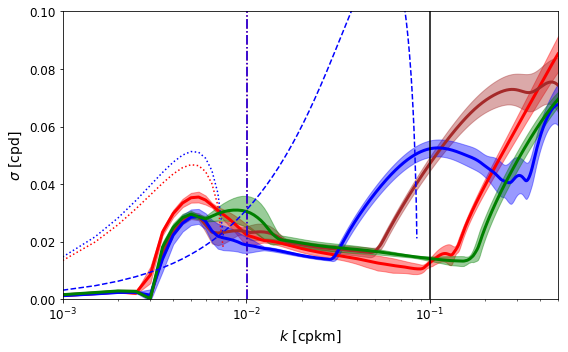

In [51]:
fig, ax = plt.subplots(figsize=(8,5))
fig.set_tight_layout(True)
for i in range(4):
    ax.plot(kx*1e3, omega[i].imag.mean(axis=-1)*86400, 
           color=colors[i], lw=3, label=r'%3s (1250km)' % seasons[i])
    ax.fill_between(kx*1e3, (omega[i].imag.mean(axis=-1)-omega[i].imag.std(axis=-1))*86400,
                   (omega[i].imag.mean(axis=-1)+omega[i].imag.std(axis=-1))*86400,
                   color=colors[i], alpha=0.4)
    if i==0 or i==2:
        ax.plot(kx*1e3, sigmady[i]*86400, color=colors[i], ls=':',
               label=r'$\sigma^{%3s}_{Eady}$' % seasons[i])
        ax.plot(kd[i]*np.ones(5)*1e3, np.linspace(0.,0.1,5), 
               color=colors[i], ls='-.', label=r'$\lambda^{-1}_{%3s}$' % seasons[i])
#         ax.plot(Ldml[i]**-1*np.ones(5)*1e3, np.linspace(0.,0.08,5), 
#                color=colors[i], ls='-.', label=r'${\lambda^{ML}_{%3s}}^{-1}$' % seasons[i])
ax.plot(kx*1e3, sigmladyw*86400, color=colors[2], ls='--',
        label=r'$\sigma_{ML\ Eady}^{%3s}$' % seasons[2])
ax.plot((2*np.diff(ds1.XC)[0])**-1*np.ones(5)*1e3, np.linspace(0.,0.1,5), 
        'k-', label=r'(2$\Delta x$)$^{-1}$')
ax.set_ylim([0.,0.1])
ax.set_xlim([1e-3,5e-1])
ax.set_xscale('log')
ax.set_xlabel(r"$k$ [cpkm]", fontsize=14)
ax.set_ylabel(r"$\sigma$ [cpd]", fontsize=14)
# ax.legend(loc='upper left', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(op.join(ddir,'Figures/Growthrate_dx5km_y125.pdf'))

In [34]:
dsave = xr.DataArray(omega.imag, dims=['seas','kx','YC'],
                    coords={'seas':np.array(['JFM','AMJ','JAS','OND']),
                           'kx':kx,'YC':N2_seas.YC.sel(YC=slice(12e5,13.05e5))}
                    ).to_dataset(name='sigma')
dsave['inv_wvln'] = xr.DataArray(kd, dims=['seas'], coords={'seas':np.array(['JFM','AMJ','JAS','OND'])})
dsave['sigmady'] = xr.DataArray(sigmady, dims=['seas','kx'],
                               coords={'seas':np.array(['JFM','AMJ','JAS','OND']),'kx':kx})
dsave['sigmlady_w'] = xr.DataArray(sigmladyw, dims=['kx'], coords={'kx':kx})
dsave.to_netcdf(op.join(ddir,'Growthrate_dx5km_y125.nc'))
dsave

<xarray.Dataset>
Dimensions:     (YC: 21, kx: 998, seas: 4)
Coordinates:
  * seas        (seas) <U3 'JFM' 'AMJ' 'JAS' 'OND'
  * kx          (kx) float64 1e-06 1.5e-06 2e-06 2.5e-06 3e-06 3.5e-06 4e-06 ...
  * YC          (YC) >f4 1202500.0 1207500.0 1212500.0 1217500.0 1222500.0 ...
Data variables:
    sigma       (seas, kx, YC) float64 1.441e-08 1.384e-08 1.33e-08 ...
    inv_wvln    (seas) float64 1.004e-05 1.005e-05 1.012e-05 1.003e-05
    sigmady     (seas, kx) float64 1.558e-07 2.299e-07 2.994e-07 3.629e-07 ...
    sigmlady_w  (kx) float64 3.621e-08 5.43e-08 7.239e-08 9.047e-08 ...

In [48]:
ds10 = xr.open_dataset(op.join(ddir,'Growthrate_dx10km_y125.nc'))
sigma10 = ds10.sigma
invwv10 = ds10.inv_wvln
sigmady10 = ds10.sigmady
sigmlady10 = ds10.sigmlady_w
sigma10

<xarray.DataArray 'sigma' (seas: 4, kx: 100, YC: 11)>
array([[[1.368644e-08, 1.368644e-08, ..., 1.368644e-08, 1.368644e-08],
        [2.683422e-08, 2.683422e-08, ..., 2.683422e-08, 2.683422e-08],
        ...,
        [1.872026e-07, 1.872026e-07, ..., 1.872026e-07, 1.872026e-07],
        [1.917571e-07, 1.917571e-07, ..., 1.917571e-07, 1.917571e-07]],

       [[1.369222e-08, 1.369222e-08, ..., 1.369222e-08, 1.369222e-08],
        [2.782192e-08, 2.782192e-08, ..., 2.782192e-08, 2.782192e-08],
        ...,
        [5.838391e-07, 5.838391e-07, ..., 5.838391e-07, 5.838391e-07],
        [5.901509e-07, 5.901509e-07, ..., 5.901509e-07, 5.901509e-07]],

       [[1.480137e-08, 1.480137e-08, ..., 1.480137e-08, 1.480137e-08],
        [2.912057e-08, 2.912057e-08, ..., 2.912057e-08, 2.912057e-08],
        ...,
        [9.610422e-07, 9.610422e-07, ..., 9.610422e-07, 9.610422e-07],
        [9.645792e-07, 9.645792e-07, ..., 9.645792e-07, 9.645792e-07]],

       [[1.307369e-08, 1.307369e-08, ..., 1.30736

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


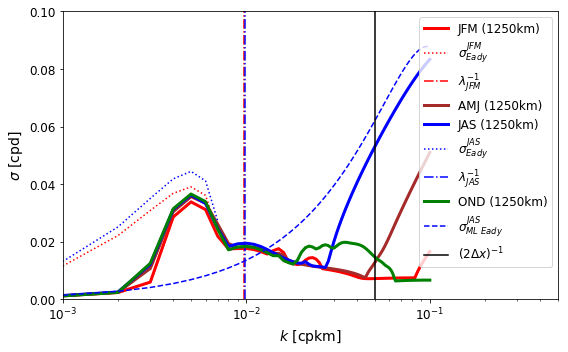

In [50]:
fig, ax = plt.subplots(figsize=(8,5))
fig.set_tight_layout(True)
for i in range(4):
    ax.plot(sigma10.kx*1e3, sigma10[i].mean(axis=-1)*86400, 
           color=colors[i], lw=3, label=r'%3s (1250km)' % seasons[i])
    ax.fill_between(sigma10.kx*1e3, (sigma10[i].mean(axis=-1)-sigma10[i].std(axis=-1))*86400,
                   (sigma10[i].mean(axis=-1)+sigma10[i].std(axis=-1))*86400,
                   color=colors[i], alpha=0.4)
    if i==0 or i==2:
        ax.plot(sigma10.kx*1e3, sigmady10[i]*86400, color=colors[i], ls=':',
               label=r'$\sigma^{%3s}_{Eady}$' % seasons[i])
        ax.plot(invwv10[i].values*np.ones(5)*1e3, np.linspace(0.,0.1,5), 
               color=colors[i], ls='-.', label=r'$\lambda^{-1}_{%3s}$' % seasons[i])
#         ax.plot(Ldml[i]**-1*np.ones(5)*1e3, np.linspace(0.,0.08,5), 
#                color=colors[i], ls='-.', label=r'${\lambda^{ML}_{%3s}}^{-1}$' % seasons[i])
ax.plot(sigma10.kx*1e3, sigmlady10*86400, color=colors[2], ls='--',
        label=r'$\sigma_{ML\ Eady}^{%3s}$' % seasons[2])
ax.plot((2*1e4)**-1*np.ones(5)*1e3, np.linspace(0.,0.1,5), 
        'k-', label=r'(2$\Delta x$)$^{-1}$')
ax.set_ylim([0.,0.1])
ax.set_xlim([1e-3,5e-1])
ax.set_xscale('log')
ax.set_xlabel(r"$k$ [cpkm]", fontsize=14)
ax.set_ylabel(r"$\sigma$ [cpd]", fontsize=14)
ax.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(op.join(ddir,'Figures/Growthrate_dx10km_y125.pdf'))